# Embedded Pseudo-Fragment Calculation for a SiC Nanotube

This notebook allows one to perform embedded pseudo-fragment calculations for a given SiC nanotube, as well as the corresponding analysis. The .yaml input files for BigDFT, corresponding data directories, and fragment .xyz files are generated by this notebook, however the .xyz files for the SiC nanotubes, including with noise, are already assumed to exist.

We write the template support functions for varying sized short nanotubes and perform cubic, linear and various fragment calculations for longer nanotubes.  In so doing we explore the effects of locality, i.e. how far from the edge of a finite SiCNT do we need to go before the support functions become bulk-like, and imperfect fragments, i.e. how much noise/internal distortion of a fragment can we add before the fragment approximation breaks down.

First load all the required modules, from BigDFT, material specific files and python libraries.

In [1]:
from BigDFT import Logfiles as lf
from BigDFT import Fragments as F
from futile.Utils import ensure_dir
from futile import YamlIO as Y

import SiC
import colours
import elements
import constants as const

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker

import numpy as np
from pylab import *
from scipy.optimize import curve_fit

import pandas as pd
from IPython.display import display
import shutil,os,yaml

import sys  
stdout = sys.stdout
reload(sys)  
sys.setdefaultencoding('utf8')
sys.stdout = stdout

## Pre-processing

First we specify various parameters for the calculations.

In [2]:
max_write_units = 10         # the number of units for generating templates for free BC: 1, ..., max_write_units
full_units = 14              # the number of units in the longer NT to be explored in detail
pw_units = 6                 # the number of units for generating templates for periodic BC
seed = 'SiC'                 # the seedname for input files
nat_ring = 14                # the number of atoms in a ring
nat_frag = nat_ring * 2      # the number of atoms in a fragment

Specify also some variables for post-processing/plotting.

In [3]:
smear = 0.1                  # Gaussian smearing for density of states calculations

# lists of markers and colors to be used for all plots
colors_rgb = [[0, 0, 0], [143, 143, 143], [124, 88, 67],
             [201, 0, 0], [255, 159, 0], [79, 147, 0], [54, 101, 255], [147, 0, 147], [40, 70, 150],
             [255, 0, 0], [201, 104, 0], [131, 201, 0], [0, 47, 255], [201, 0, 201], [0, 30, 110]]
colors = []
for rgb in colors_rgb:
    html = colours.rgb_to_html(rgb)
    colors.append(html)

markers = ['s', 'o', '^', 'v', 'd', 'p', 'h', 'D', '*']

# for the earlier plots
widths = [5, 2, 2, 2, 2, 2, 2, 2, 2]
sizes = [8, 5, 5, 5, 5, 5, 5, 5, 5]

# for the later plots
ms = [14, 10]
lw = [5, 3]

Define a function which will set some of the plot details (to improve readability later on).

In [4]:
def set_plot_parameters(ax, xmin, xmax, ymin, ymax, xlabel, ylabel, xtlabel, ytlabel,
                        dx, dy, nmx, nmy, shrink, key_loc): 

    if xmin != 'DEFAULT':
        ax.set_xlim(xmin, xmax)
    if ymin != 'DEFAULT':
        ax.set_ylim(ymin, ymax)
    
    if xlabel != 'NONE':
        ax.set_xlabel(xlabel)
        
    if ylabel != 'NONE':
        ax.set_ylabel(ylabel)

    pad = 8
    mjl = 6
    mnl = 3

    if xtlabel == 'NOLABEL':
        label = False
    else:
        label = True
        
    if dx == 'NONE':
        ax.get_xaxis().set_ticks([])
    else:
        ax.tick_params(axis='x', which='major', direction='in', pad=pad, length=mjl,
                   bottom=True, top=True, labelbottom=label, labeltop=False)
        ax.tick_params(axis='x', which='minor', direction='in', pad=pad, length=mnl,
                   bottom=True, top=True, labelbottom=label, labeltop=False)

    if ytlabel == 'NOLABEL':
        label = False
    else:
        label = True
    
    if dy == 'NONE':
        ax.get_yaxis().set_ticks([])
    else:
        ax.tick_params(axis='y', which='major', direction='in', pad=pad, length=mjl,
                    left=True, right=True, labelleft=label, labelright=False)
        ax.tick_params(axis='y', which='minor', direction='in', pad=pad, length=mnl,
                   left=True, right=True, labelleft=label, labelright=False)
    
    if dx != 'DEFAULT' and dx != 'NONE':
        ax.xaxis.set_major_locator(ticker.MultipleLocator(dx))
        if nmx != 'DEFAULT':
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(dx / nmx))
    if dy != 'DEFAULT' and dy != 'NONE':
        ax.yaxis.set_major_locator(ticker.MultipleLocator(dy))
        if nmy != 'DEFAULT':  
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(dy / nmy))
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * shrink, box.height])
    
    if key_loc == 'outside':
        ax.legend(loc='center left', ncol=1, bbox_to_anchor=(1, 0.5))
    elif key_loc != 'NONE':
        ax.legend(loc=key_loc, ncol=1)

Define a function for fitting to the data.  For now this is just a linear fit, but could be easily generalized.

In [5]:
def line(x, A, B):
    return A*x + B

Create input files, data directories etc. for the finite NTs cubic, linear, template and fragment calculations.

First the cubic .yaml files.

In [6]:
# define a basic dictionary
cubic_dict = {'dft': {'hgrids': 0.35, 'rmult': [6.0, 8.0], 'ixc': 'PBE (ABINIT)',
                      'disablesym': True, 'gnrm_cv': 1.e-5, 'output_denspot': 21,
                      'itermax': 40, 'nrepmax': 8, 'itermax_virt': 100}}

# set the name of the file and associated .xyz files
cname = seed+"_"+str(full_units)
cnat = full_units * nat_ring * 2
pos_dict = {'posinp': cname}
rad_dict = {'radical': cname+'_cubic'}
cubic_dict.update(pos_dict)
cubic_dict.update(rad_dict)

# specify the number of virtual KS states in proportion to the number of occupied KS states
nks = cnat * 2
nvt = nks / 8
nov = nvt * 4
virt_dict = {'norbv': nov, 'nvirt': nvt}
cubic_dict['dft'].update(virt_dict)

# write the final dictionary to the .yaml file
Y.dump(cubic_dict,cname+"_cubic.yaml")

Now the linear .yaml files.

In [7]:
# define a basic dictionary
linear_dict = {'import': 'linear_laura',
               'dft': {'hgrids': 0.35, 'rmult': [6.0, 8.0], 'inputpsiid': 'linear',
                       'ixc': 'PBE (ABINIT)', 'disablesym': True, 'output_denspot': 21},
               'perf': {'hamapp_radius_incr': 8},
               'lin_general': {'nit': 200, 'rpnrm_cv': 1.0e-11, 'output_wf': 0, 'output_mat': 21,
                       'calculate_onsite_overlap': True, 'subspace_diag': True},
               'lin_basis': {'nit': 2, 'gnrm_cv': 2.0e-3},
               'lin_kernel': {'alphamix': 0.2, 'linear_method': 'FOE', 'rpnrm_cv': 1.0e-9},
               'lin_basis_params': {'rloc_kernel': 15, 'rloc_kernel_foe': 20,
                       'C': {'nbasis': 4, 'rloc': 8.5}, 'Si': {'nbasis': 4, 'rloc': 8.5}},
               'ig_occupation': {'C': {'2s': 2, '2p': ['2/3', '2/3', '2/3']},
                       'Si': {'3s': 2, '3p': ['2/3', '2/3', '2/3']}}}


# set the name of the file and associated .xyz files
lname = seed+"_"+str(full_units)
lnat = full_units * nat_ring * 2
pos_dict = {'posinp': cname}
rad_dict = {'radical': cname+'_linear'}
linear_dict.update(pos_dict)
linear_dict.update(rad_dict)

# write the final dictionary to the .yaml file
Y.dump(linear_dict,lname+"_linear.yaml")

Now the read and write .yaml files.

In [8]:
# define basic dictionaries
write_dict =  {'import': 'linear_laura',
               'dft': {'hgrids': 0.3, 'rmult': [6.0, 8.0], 'inputpsiid': 'linear',
                       'ixc': 'PBE (ABINIT)', 'disablesym': True},
               'perf': {'hamapp_radius_incr': 8},
               'lin_general': {'nit': 200, 'rpnrm_cv': 1.0e-11, 'output_wf': 1, 'output_mat': 21,
                       'output_fragments': 1, 'frag_num_neighbours': 0},
               'lin_basis': {'nit': 2, 'gnrm_cv': 2.0e-3},
               'lin_kernel': {'alphamix': 0.2, 'linear_method': 'FOE', 'rpnrm_cv': 1.0e-9},
               'lin_basis_params': {'rloc_kernel': 15, 'rloc_kernel_foe': 20,
                       'C': {'nbasis': 4, 'rloc': 8.5}, 'Si': {'nbasis': 4, 'rloc': 8.5}},
               'ig_occupation': {'C': {'2s': 2, '2p': ['2/3', '2/3', '2/3']},
                       'Si': {'3s': 2, '3p': ['2/3', '2/3', '2/3']}}}

read_dict =  {'import': 'linear_laura',
               'dft': {'hgrids': 0.35, 'rmult': [6.0, 8.0], 'inputpsiid': 'linear_restart',
                       'ixc': 'PBE (ABINIT)', 'disablesym': True, 'output_denspot': 21},
               'perf': {'hamapp_radius_incr': 8, 'experimental_mode': False,
                        'adjust_kernel_iterations': False, 'adjust_kernel_threshold': False},
               'lin_general': {'hybrid': False, 'kernel_restart_mode': 'kernel', 'subspace_diag': True,
                               'nit': 1, 'output_wf': 0, 'output_mat': 0},
               'lin_basis': {'nit': 1},
               'lin_kernel': {'alphamix': 0.1, 'linear_method': 'FOE', 'nit': [0, 100],
                              'idsx': 4, 'rpnrm_cv': 1.0e-11},
               'lin_basis_params': {'rloc_kernel': 15, 'rloc_kernel_foe': 20,
                       'C': {'nbasis': 4, 'rloc': 8.5}, 'Si': {'nbasis': 4, 'rloc': 8.5}},
               'ig_occupation': {'C': {'2s': 2, '2p': ['2/3', '2/3', '2/3']},
                       'Si': {'3s': 2, '3p': ['2/3', '2/3', '2/3']}}}


# first make the write.yaml files for each of the template setups
for w in range(2,max_write_units+1,2):
    wname = seed+"_"+str(w)
    wnat = w * nat_ring * 2
    wnum_frags = wnat / nat_frag
    
    pos_dict = {'posinp': wname}
    rad_dict = {'radical': wname+'_fw'}
    write_dict.update(pos_dict)
    write_dict.update(rad_dict)
    
    # label fragments as frag$i_fw$w where i is the fragment index in the system  
    wfrag_dict = {'frag': {'frag'+str(frag)+'_fw'+str(w): [frag] for frag in range(1, wnum_frags + 1)}}
    write_dict.update(wfrag_dict)
    Y.dump(write_dict,wname+"_fw.yaml")
    
    # also create the corresponding directories
    sysdir='data-'+wname+'_fw'
    ensure_dir(sysdir)
    for frag in wfrag_dict['frag']:
        ensure_dir(sysdir+'/data-'+frag)
        
    # and the template .xyz files
    wsys = F.System(xyz=wname+'.xyz',nat_reference=nat_frag)
    for frag in range(1,wnum_frags+1):
        template = wsys.fragments[frag-1]
        template.set_id('frag'+str(frag)+'_fw'+str(w))
        template.xyz(filename=sysdir+'/'+template.id+'.xyz') #,units=) - shouold be angstrom, need to fetch correctly
   
    # make the read.yaml file for each of the template setups
    rname = seed+"_"+str(full_units)
    rnat = full_units * nat_ring * 2
    rnum_frags = rnat / nat_frag
    pos_dict = {'posinp': rname}
    rad_dict = {'radical': wname+'_fw'}
    read_dict.update(pos_dict)
    read_dict.update(rad_dict)
    
    # use the appropriate template fragment
    fdict1 = {'frag'+str(f)+'_fw'+str(w): [f] for f in range(1,w/2)} 
    fc=w/2
    fdict2 = {'frag'+str(fc)+'_fw'+str(w): [f for f in range(fc,rnum_frags-w/2+2,2)]}  
    fc=w/2+1
    fdict3 = {'frag'+str(fc)+'_fw'+str(w): [f for f in range(fc,rnum_frags-w/2+2,2)]}
    fdict4 = {'frag'+str(f)+'_fw'+str(w): [rnum_frags - wnum_frags + f] for f in range(w-w/2+2,w+1)}
    fdict4.update(fdict3)
    fdict4.update(fdict2)
    fdict4.update(fdict1)
    rfrag_dict = {'frag': fdict4}
    read_dict.update(rfrag_dict)
    Y.dump(read_dict,rname+"_fr"+str(w)+".yaml")
    
    # finally, we make the read.yaml file for the free calculation which uses a combination
    # of free and periodic templates - take a single value of w
    # IMPORTANT: the periodic and finite templates are in a different directory and therefore need
    # copying/linking to the finite directory
    # IMPORTANT: note that both calculations will therefore write the electronic_density.cube file to the
    # same directory, so a copy must be made before launching the second of the two calculations
    if w == 8:
        fdict1 = {'frag'+str(f)+'_fw'+str(w): [f] for f in range(1,w/2)} 
        fc=w/2
        fdict2 = {'frag_fw'+str(pw_units): [f for f in range(fc,rnum_frags-w/2+2)]}  
        fdict4 = {'frag'+str(f)+'_fw'+str(w): [rnum_frags - wnum_frags + f] for f in range(w-w/2+2,w+1)}
        fdict4.update(fdict2)
        fdict4.update(fdict1)
        rfrag_dict = {'frag': fdict4}
        read_dict.update(rfrag_dict)
        Y.dump(read_dict,rname+"_fr"+str(w)+"m.yaml")


Do the same for the periodic NT calculations, and the finite NT fragment calculation which uses a periodic template.

First the cubic .yaml file.

In [9]:
cname = seed+"p_"+str(full_units)
cnat = full_units * nat_ring * 2
pos_dict = {'posinp': cname}
rad_dict = {'radical': cname+'_cubic'}
cubic_dict.update(pos_dict)
cubic_dict.update(rad_dict)
# specify the number of virtual KS states in proportion to the number of occupied KS states
nks = cnat * 2
nvt = nks / 8
nov = nvt * 4
virt_dict = {'norbv': nov, 'nvirt': nvt}
cubic_dict['dft'].update(virt_dict)
Y.dump(cubic_dict,cname+"_cubic.yaml")

Then the linear .yaml file.

In [10]:
lname = seed+"p_"+str(full_units)
lnat = full_units * nat_ring * 2
pos_dict = {'posinp': cname}
rad_dict = {'radical': cname+'_linear'}
linear_dict.update(pos_dict)
linear_dict.update(rad_dict)
Y.dump(linear_dict,lname+"_linear.yaml")

Now the read and write .yaml files.

In [11]:
# first make the write.yaml file
w = pw_units
wname = seed+"p_"+str(w)
wnat = w * nat_ring * 2
wnum_frags = wnat / nat_frag
    
pos_dict = {'posinp': wname}
rad_dict = {'radical': wname+'_fw'}
write_dict.update(pos_dict)
write_dict.update(rad_dict)
    
# label fragments as frag_fw$w 
wfrag_dict = {'frag': {'frag_fw'+str(w): [frag for frag in range(1, wnum_frags + 1)]}}
write_dict.update(wfrag_dict)
Y.dump(write_dict,wname+"_fw.yaml")
    
# also create the corresponding directory
sysdir='data-'+wname+'_fw'
ensure_dir(sysdir)
for frag in wfrag_dict['frag']:
    ensure_dir(sysdir+'/data-'+frag)
        
# and the template .xyz file
wsys = F.System(xyz=wname+'.xyz',nat_reference=nat_frag)
template = wsys.fragments[0]
template.set_id('frag'+'_fw'+str(w))
template.xyz(filename=sysdir+'/'+template.id+'.xyz')

# make the read.yaml file
rname = seed+"p_"+str(full_units)
rnat = full_units * nat_ring * 2
rnum_frags = rnat / nat_frag  
pos_dict = {'posinp': rname}
rad_dict = {'radical': wname+'_fw'}
read_dict.update(pos_dict)
read_dict.update(rad_dict) 
rfrag_dict = {'frag': {'frag_fw'+str(w): [frag for frag in range(1, rnum_frags + 1)]}}
read_dict.update(rfrag_dict)
Y.dump(read_dict,rname+"_fr"+str(w)+".yaml")

# here we also make the read.yaml file for the free calculation which uses the periodic fragment
# IMPORTANT: note that both calculations will write the electronic_density.cube file to the
# same directory, so a copy must be made before launching the second of the two calculations
rname = seed+"_"+str(full_units)
pos_dict = {'posinp': rname}
rad_dict = {'radical': wname+'_fw'}
read_dict.update(pos_dict)
read_dict.update(rad_dict)
rfrag_dict = {'frag': {'frag_fw'+str(w): [frag for frag in range(1, rnum_frags + 1)]}}
read_dict.update(rfrag_dict)
Y.dump(read_dict,rname+"_fr"+str(w)+"p.yaml")

## Extract Information for Analysis


Extract the energies, DoS etc. from the logfiles for each setup.

In [12]:
calc_types = ['cubic', 'linear', 'fr6p', 'fr2', 'fr4', 'fr6', 'fr8', 'fr10', 'fr8m']
labels = ['Cubic', 'Linear', '1 PFrag', '2 PFrags', '4 PFrags', '6 PFrags',
          '8 PFrags', '10 PFrags', '7 PFrags']
calc_typesp = list( calc_types[i] for i in [0, 1, pw_units/2+2] )
labelsp = ['Cubic', 'Linear', '1 PFrag']
calc_typespn = list( calc_types[i] for i in [1, pw_units/2+2] )
labelspn = ['Linear', '1 PFrag']

# finite NT
curves = [SiC.get_data(seed, calc_type, full_units, smear, labels[i], '0') 
          for i, calc_type in enumerate(calc_types)]
# periodic NT
curvesp = [SiC.get_data(seed+'p', calc_type, full_units, smear, labelsp[i], '0') 
          for i, calc_type in enumerate(calc_typesp)]

Write parameter files for v_sim, which can be used to visualize the SiCNTs with the appropriate fragment colouring.

In [13]:
tf = nat_ring * full_units * 2 / nat_frag
pf = nat_ring * pw_units * 2 / nat_frag
SiC.write_vsim_file(w/2, max_write_units/2, tf, colors_rgb, False, False)
for w in range(2,max_write_units+1,2):
    SiC.write_vsim_file(w/2, max_write_units/2, tf, colors_rgb, True, False)
    wf = nat_ring * w * 2 / nat_frag
    SiC.write_vsim_file(w/2, max_write_units/2, wf, colors_rgb, True, False)
    
# the periodic case is special
SiC.write_vsim_file(1, max_write_units/2, tf, colors_rgb, True, True)
SiC.write_vsim_file(1, max_write_units/2, pf, colors_rgb, True, True)

writing to  v_sim_nf.res
writing to  v_sim_2_14.res
writing to  v_sim_2_2.res
writing to  v_sim_4_14.res
writing to  v_sim_4_4.res
writing to  v_sim_6_14.res
writing to  v_sim_6_6.res
writing to  v_sim_8_14.res
writing to  v_sim_8_8.res
writing to  v_sim_10_14.res
writing to  v_sim_10_10.res
writing to  v_sim_2_14p.res
writing to  v_sim_2_6p.res


## Effect of Noise

Before continuing with the analysis of the above calculations, we first consider what happens when some random noise is added to the coordinates of the full system.  This will give some indications as to the influence of geometrical distortions on energies.

We focus on the periodic NT, with the aim of exploring the effect of imperfect templates without the addition of edge effects.  Note that the position files with a certain amount of random noise have been generated elsewhere.  From now on we only compare the pseudo-fragment and linear scaling results.  First we generate the input files.

Array of values indicating how much random noise was added to the atomic positions - the .xyz files are named accordingly.

In [14]:
nmax = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

There is no need to re-generate the templates so here we just make linear and read input files.

In [15]:
# we do not need to calculate the density of states or electronic densities for either system
linear_dict['lin_general'].update({'subspace_diag': False}) 
linear_dict['dft'].update({'output_denspot': 0}) 
read_dict['lin_general'].update({'subspace_diag': False}) 
read_dict['dft'].update({'output_denspot': 0}) 

# set the variables for the write file
w = pw_units
wname = seed+"p_"+str(w)
wnat = w * nat_ring * 2
wnum_frags = wnat / nat_frag    

# make the read.yaml file for each of the noise values
for n in nmax:
    rname = seed+"p_"+str(full_units)+'_'+str(n)
    rnat = full_units * nat_ring * 2
    rnum_frags = rnat / nat_frag  

    pos_dict = {'posinp': rname}
    rad_dict = {'radical': wname+'_fw'}
    read_dict.update(pos_dict)
    read_dict.update(rad_dict)
    
    rfrag_dict = {'frag': {'frag_fw'+str(w): [frag for frag in range(1, rnum_frags + 1)]}}
    read_dict.update(rfrag_dict)
    Y.dump(read_dict,rname+"_fr"+str(w)+".yaml")

    # finally the linear .yaml file
    lname = seed+"p_"+str(full_units)+'_'+str(n)
    lnat = full_units * nat_ring * 2
    pos_dict = {'posinp': cname}
    rad_dict = {'radical': cname+'_linear'}
    linear_dict.update(pos_dict)
    linear_dict.update(rad_dict)
    Y.dump(linear_dict,lname+"_linear.yaml")

Extract data from the different calculations for plotting.

In [16]:
curvesn = [[SiC.get_data(seed+'p',calc_type, full_units, smear, labelsp[i], str(n),
                         get_dos=False, get_cubic=False) 
                  for i, calc_type in enumerate(calc_typespn)] for n in nmax]

Plot the different quantities for the different calculations.  Here we are interested in understanding how the noise affects the errors and how this correlates with the maximum value of the Wahba cost function.  Using this correlation we can then apply a correction to the total energies, which results in consistently small errors independent of the level of noise.

First we extract the relevant data for plotting.

In [17]:
noise = [0.0]
errors = [curvesp[2]['error_linear']]
wahbas = [curvesp[2]['wahba']['av']]
std = [curvesp[2]['wahba']['std']]
for n in range(len(nmax)):
    data = curvesn[n][1]
    errors.append(data['error_linear'])
    noise.append(data['noise']['av'])
    wahbas.append(data['wahba']['av'])
    std.append(data['wahba']['std'])
    
# fit wahba vs error
full_wahbas = [0.0001*w for w in range(0,10001)]
mn, cn = curve_fit(line, wahbas, errors, sigma=std)[0]
full_est_errors = [line(wahba, mn, cn) for wahba in full_wahbas]
est_errors = [line(wahba, mn, cn) for wahba in wahbas]
corr_errors = [error - est_errors[e] for e, error in enumerate(errors)]
abs_corr_errors = [abs(corr_error) for corr_error in corr_errors]

Set some variables to be used for the graph.

In [18]:
# define axes labels
label_noise = '$|\Delta R| (\AA)$'
label_error = '$E - E^{\mathrm{linear}}$ (eV/atom)'
label_wahba = '$J_{\mathrm{Av.}} (\AA^2)$'

# set the values for the x and y ranges
emin = 0.00001
emax = 0.5
nsmin = 5.0e-4
nsmax = 0.04
wmin = 1.0e-5
wmax = 0.1
ethresh = 0.005

Plot the data.

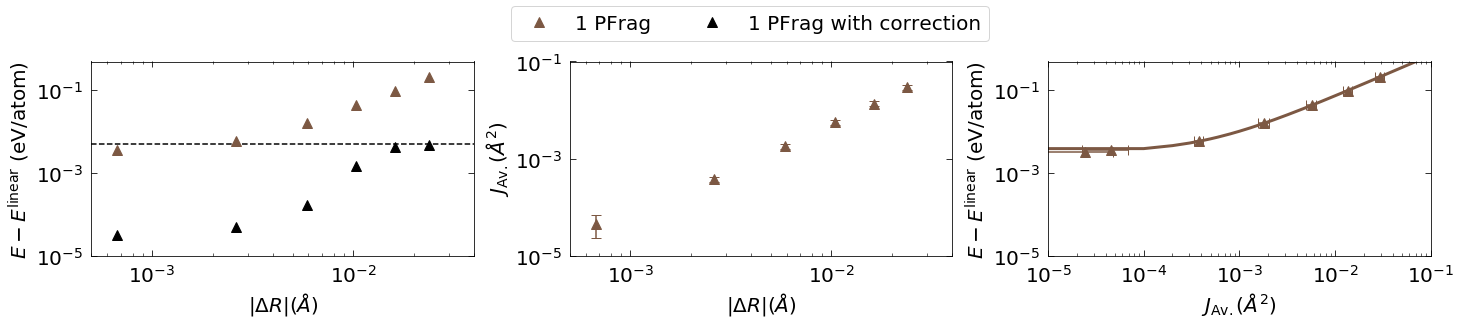

In [19]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 3, figsize=(24,4))
fig.subplots_adjust(wspace=0.25)

# we only need to plot the pseudo-fragment results
i = 2 

# first plot noise vs error
ls = []
ax[0].axhline(y=ethresh, color=colors[0], ls='--')
label = curvesp[i]['label']
l = ax[0].loglog(noise, errors, marker=markers[i], ms=ms[1], color=colors[i], ls='', label=label)
ls.append(l)
label = curvesp[i]['label']+' with correction'
l = ax[0].loglog(noise, abs_corr_errors, marker=markers[i], ms=ms[1], color=colors[0], ls='', label=label)
ls.append(l)
set_plot_parameters(ax[0], nsmin, nsmax, emin, emax, label_noise, label_error, 'DEFAULT', 'DEFAULT',
                    'DEFAULT', 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'NONE')

# then plot noise vs Wahba
ax[1].set_yscale('log', nonposy='clip')   
ax[1].set_xscale('log', nonposx='clip')   
ax[1].errorbar(noise, wahbas, marker=markers[i], ms=ms[1], color=colors[i], ls='',
                   yerr=[std, std], capsize=5)
set_plot_parameters(ax[1], nsmin, nsmax, wmin, wmax, label_noise, label_wahba, 'DEFAULT', 'DEFAULT',
                    'DEFAULT', 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'NONE')

# finally plot Wahba vs error
ax[2].set_yscale('log', nonposy='clip')   
ax[2].set_xscale('log', nonposx='clip')   
ax[2].errorbar(wahbas, errors, marker=markers[i], ms=ms[1], color=colors[i], ls='',
                 xerr=[std, std], capsize=5)
ax[2].loglog(full_wahbas, full_est_errors, marker='', color=colors[i], ls='-', lw=lw[1])
set_plot_parameters(ax[2], wmin, wmax, emin, emax, label_wahba, label_error, 'DEFAULT', 'DEFAULT',
                    'DEFAULT', 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'NONE')

lss = ls[0] + ls[1]
for i in range(1,len(ls)-1):
    lss = lss + ls[i+1]    
labs = [l.get_label() for l in lss]
fig.legend(lss, labs, loc=[0.35,0.87], ncol=2)

plt.subplots_adjust(top=0.8)

plt.show()

## Basic Calculation Outputs

We return now to the above calculations, summarizing the energies, band gaps etc. from the different calculation setups in a table.  The energy errrors are calculated with respect to the linear scaling reference.

First estimate the errors using the fit from the noise plot.

In [20]:
predp_e = [0, 0]
for i, data in enumerate(curvesp):
    if i < 2:
        continue
    predp_e.append(1000*line(data['wahba']['av'], mn, cn))
    
predf_e = [0, 0]
for i, data in enumerate(curves):
    if i < 2:
        continue
    predf_e.append(1000*line(data['wahba']['av'], mn, cn))

Generate a table summarizing the relevant data.

In [21]:
column_labels = ["$E$ (eV/atom)",
            "$|\Delta E|$ (meV/atom)","$\Delta_{\mathrm{gap}}$ (eV)",               
            "Av. $J$ ($\unicode{x212B}^2$)", "Max. $J$ ($\unicode{x212B}^2$)",
            "Pred. $|\Delta E|$ (meV/atom)"]

row_labels = ['Periodic NT']
for data in curvesp:
    row_labels.append(data['label'])
row_labels.append('Finite NT')
for data in curves:
    row_labels.append(data['label'])

table_datap = []
blank_row = np.array([[''] * 6])
for i, data in enumerate(curvesp):
    table_datap.append(['{0:.3f}'.format(data['energy']),
                       '{0:.1f}'.format(1000*data['error_linear']),
                       '{0:.2f}'.format(data['gap']),
                       '{0:.4f}'.format(data['wahba']['av']),
                       '{0:.4f}'.format(data['wahba']['max']),
                       '{0:.1f}'.format(predp_e[i])])
tdatap = np.array(table_datap)
table_dataf = []

for i, data in enumerate(curves):
    table_dataf.append(['{0:.3f}'.format(data['energy']),
                       '{0:.1f}'.format(1000*data['error_linear']),
                       '{0:.2f}'.format(data['gap']),
                       '{0:.4f}'.format(data['wahba']['av']),
                       '{0:.4f}'.format(data['wahba']['max']),
                       '{0:.1f}'.format(predf_e[i])])
tdataf = np.array(table_dataf)
table_data = np.concatenate((blank_row, tdatap, blank_row, tdataf))

df = pd.DataFrame(table_data, columns=column_labels, index=row_labels)
df.dtypes     
d = dict(selector="th", props=[('text-align', 'left')])
display(df)

$E$ (eV/atom) $|\Delta E|$ (meV/atom)  \
Periodic NT                                         
Cubic            -130.802                     9.6   
Linear           -130.793                     0.0   
1 PFrag          -130.789                     3.3   
Finite NT                                           
Cubic            -130.729                     9.9   
Linear           -130.719                     0.0   
1 PFrag          -129.438                  1280.6   
2 PFrags         -125.087                  5632.4   
4 PFrags         -129.770                   948.9   
6 PFrags         -130.675                    44.0   
8 PFrags         -130.712                     7.0   
10 PFrags        -130.714                     4.8   
7 PFrags         -130.710                     9.2   

            $\Delta_{\mathrm{gap}}$ (eV) Av. $J$ ($\unicode{x212B}^2$)  \
Periodic NT                                                              
Cubic                               2.37                        0.0000   
Linear                              3.79                        0.0000   
1 PFrag                             3.74                        0.0000   
Finite NT                                                                
Cubic                               2.22                        0.0000   
Linear                              3.63                        0.0000   
1 PFrag                             1.45                        4.3473   
2 PFrags                            1.82                       25.9196   
4 PFrags                            3.08                        0.1712   
6 PFrags                            3.59                        0.0157   
8 PFrags                            3.62                        0.0010   
10 PFrags                           3.62                        0.0003   
7 PFrags                            3.62                        0.0007   

            Max. $J$ ($\unicode{x212B}^2$) Pred. $|\Delta E|$ (meV/atom)  
Periodic NT                                                               
Cubic                               0.0000                           0.0  
Linear                              0.0000                           0.0  
1 PFrag                             0.0000                           3.4  
Finite NT                                                                 
Cubic                               0.0000                           0.0  
Linear                              0.0000                           0.0  
1 PFrag                            30.2885                       30821.7  
2 PFrags                           32.8376                      183751.3  
4 PFrags                            0.2760                        1216.8  
6 PFrags                            0.0309                         114.6  
8 PFrags                            0.0021                          10.6  
10 PFrags                           0.0012                           5.0  
7 PFrags                            0.0018                           8.2

## Density of States

Plot the DoS for the different setups.

First set some parameters for the plot.

In [22]:
elabel = 'Energy (eV)'
dlabel = 'DoS (arb. units)'
emin = -15
emax = 4
dmin = 0
dmax = 200
de = 5

Plot the DoS for the periodic NT.

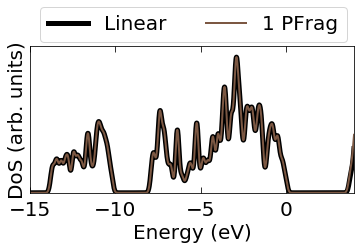

In [23]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(5.8,2.7))

plt.plot(curvesp[1]['dos_energies']-curvesp[1]['fermi'], curvesp[1]['dos'], marker="", 
            ls='-', lw=widths[0], label=curvesp[1]['label'], color=colors[0])
plt.plot(curvesp[2]['dos_energies']-curvesp[2]['fermi'], curvesp[2]['dos'], marker="", 
            ls='-', lw=widths[2], label=curvesp[2]['label'], color=colors[2])
ax = plt.axes()

set_plot_parameters(ax, emin, emax, dmin, dmax, elabel, dlabel, 'DEFAULT', 'DEFAULT',
                    de, 'NONE', 'DEFAULT', 'DEFAULT', 1.0, 'NONE')

plt.legend(loc=[0.03,1.03], ncol=2)
plt.show()

Plot the DoS for the different setups for the finite NT.  Since the 10 and 7 PFrag plots are otherwise indistinguishable, they are not plotted.

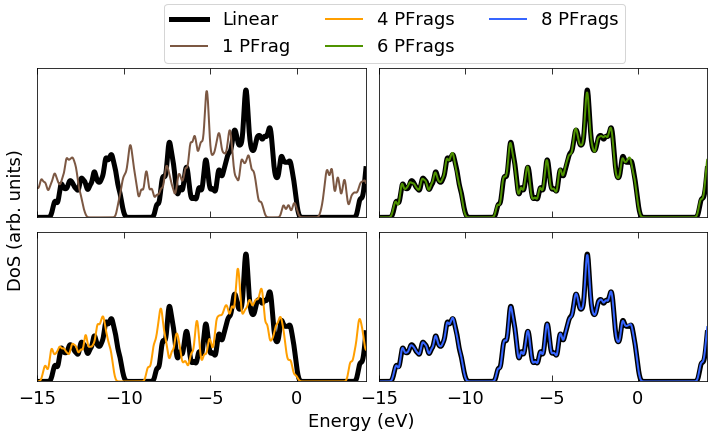

In [24]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,6))
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.04)
fig.text(0.5, 0.02, elabel, ha='center')
fig.text(0.09, 0.5, dlabel, va='center', rotation='vertical')

ls = []
for i, data in enumerate(curves):
    # skip certain cases where we don't need to plot
    if i == 0 or i == 1 or i == 3 or i == 7 or i == 8:
        continue
    if i == 2:
        a = 0
    else:
        a = (i-1)%2
    if i <= 4: 
        b = 0
    else:
        b = 1
    l = ax[a][b].plot(curves[1]['dos_energies']-curves[1]['fermi'], curves[1]['dos'], marker="", 
             ls='-', lw=widths[0], label=curves[1]['label'], color=colors[0])
    if i == 2:
        ls.append(l)
        
    l = ax[a][b].plot(data['dos_energies']-data['fermi'], data['dos'], marker="", 
             ls='-', lw=widths[i], label=data['label'], color=colors[i])
    ls.append(l)

    if a == 0:
        xtlabel = 'NOLABEL'
    else:
        xtlabel = 'DEFAULT'
        
    set_plot_parameters(ax[a][b], emin, emax, dmin, dmax, 'NONE', 'NONE', xtlabel, 'DEFAULT',
                de, 'NONE', 'DEFAULT', 'DEFAULT', 1.0, 'NONE')

lss = ls[0] + ls[1]
for i in range(1,len(ls)-1):
    lss = lss + ls[i+1]    
labs = [l.get_label() for l in lss]
fig.legend(lss, labs, loc=[0.23,0.855], ncol=3)
plt.subplots_adjust(top=0.85)
    
plt.show()

## Onsite Overlap Matrix

Read in the onsite overlap matrices for the periodic and finite linear scaling calculations.

In [25]:
# number of support functions for each species type
nsf_c = 4
nsf_si = 4
oo_full = SiC.read_onsite_overlap('data-'+seed+'_'+str(full_units)+'_linear/overlap_onsite.bin',
                                nat_ring, full_units, nsf_c, nsf_si)
oo_fullp = SiC.read_onsite_overlap('data-'+seed+'p_'+str(full_units)+'_linear/overlap_onsite.bin',
                                nat_ring, full_units, nsf_c, nsf_si)

Extract the relevant information from the complete onsite overlap matrices.

In [26]:
# we want the middle group of atoms as the reference
ref_atom = nat_ring * (full_units - 1) + 1
last_ref_atom = ref_atom + nat_ring * 2 - 1

# extract the information we want for plotting
oo = SiC.process_onsite_overlap(nat_ring, nat_frag, full_units, nsf_c, nsf_si, oo_full, ref_atom)
oop = SiC.process_onsite_overlap(nat_ring, nat_frag, full_units, nsf_c, nsf_si, oo_fullp, ref_atom)

Plot the onsite overlap matrices - the shaded regions indicate the region containing the reference atoms.

First set some parameters for the plot.

In [27]:
dmin = 0.0
dmax = curves[0]['dmax']
dmaxp = curvesp[0]['dmax']
buffer = 0.5

oomin = 1.e-8
oomax = 1
dlabel = 'Distance along NT ($\AA$)'
olabel = '1 - $S^{\mathrm{onsite}}$'

Find the minimum and maximum distance in the centre region.

In [28]:
mind = dmaxp
maxd = 0.0
for iat in range(ref_atom,last_ref_atom+1):
    mind = min(mind, curvesp[0]['distances'][iat-1])
    maxd = max(maxd, curvesp[0]['distances'][iat-1])

Find the average, minimum, maximum and standard deviation of the onsite overlap.

In [29]:
oo_avp = 0.0
noop = 0
max_oop = 0.0
min_oop = 1.0
for i, ooi in enumerate(oop['s']):
    # extract the element to simplify the lines below
    oos = 1.0 - abs(oop['s'][i][2])
    oopx = 1.0 - abs(oop['px'][i][2])
    oopy = 1.0 - abs(oop['py'][i][2])
    oopz = 1.0 - abs(oop['pz'][i][2])
    
    max_oop = max(max_oop, abs(oos), abs(oopx), abs(oopy), abs(oopz))
    min_oop = min(min_oop, abs(oos), abs(oopx), abs(oopy), abs(oopz))
    
    oo_avp += (abs(oos) + abs(oopx) + abs(oopy) + abs(oopz))
    noop += 4

oo_avp /= noop    

oo_stdp = 0.0
for i, ooi in enumerate(oop['s']):
    # extract the element to simplify the lines below
    oos = 1.0 - abs(oop['s'][i][2])
    oopx = 1.0 - abs(oop['px'][i][2])
    oopy = 1.0 - abs(oop['py'][i][2])
    oopz = 1.0 - abs(oop['pz'][i][2])

    oo_stdp += (oos - oo_avp)**2 + (oopx - oo_avp)**2 + (oopy - oo_avp)**2 + (oopz - oo_avp)**2

oo_stdp = sqrt(oo_stdp / noop)

Plot the onsite overlap for the periodic NT.

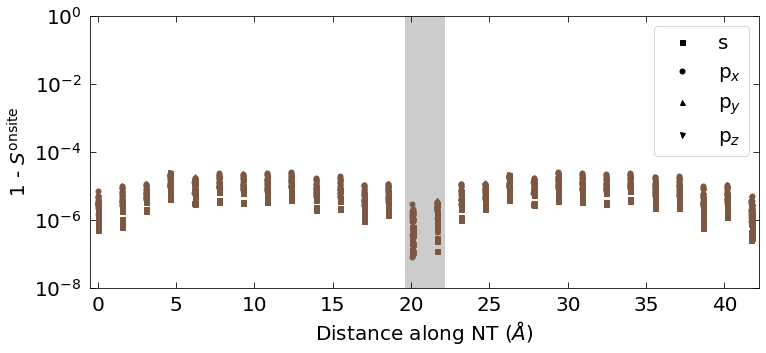

In [30]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12,5))
ax = plt.axes()
ax.set_yscale('log', nonposy='clip')   

plt.axvspan(mind - buffer, maxd + buffer, color=colors[0], alpha=0.2, lw=0)
 
for i, ooi in enumerate(oop['s']):
    iat = oop['s'][i][0]  
    ifrag = oop['s'][i][1]
    fn = 2
            
    # extract the element to simplify the lines below
    oos = 1.0 - abs(oop['s'][i][2])
    oopx = 1.0 - abs(oop['px'][i][2])
    oopy = 1.0 - abs(oop['py'][i][2])
    oopz = 1.0 - abs(oop['pz'][i][2])
        
    plt.semilogy(curvesp[0]['distances'][iat-1], abs(oos), marker=markers[0], ms=sizes[2], color=colors[fn])
    plt.semilogy(curvesp[0]['distances'][iat-1], abs(oopx), marker=markers[1], ms=sizes[3], color=colors[fn])
    plt.semilogy(curvesp[0]['distances'][iat-1], abs(oopy), marker=markers[2], ms=sizes[4], color=colors[fn])
    plt.semilogy(curvesp[0]['distances'][iat-1], abs(oopz), marker=markers[3], ms=sizes[4], color=colors[fn])   

#just for the sake of the key
plt.semilogy(dmaxp+1, 1, color=colors[0], ls='', marker=markers[0], ms=sizes[2], label='s')
plt.semilogy(dmaxp+1, 1, color=colors[0], ls='', marker=markers[1], ms=sizes[3], label='p$_x$')
plt.semilogy(dmaxp+1, 1, color=colors[0], ls='', marker=markers[2], ms=sizes[4], label='p$_y$')
plt.semilogy(dmaxp+1, 1, color=colors[0], ls='', marker=markers[3], ms=sizes[5], label='p$_z$')

set_plot_parameters(ax, dmin - buffer, dmaxp + buffer, oomin, oomax, dlabel, olabel, 'DEFAULT', 'DEFAULT',
                'DEFAULT', 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'upper right')

plt.show()

Find the minimum and maximum distance in the centre region.

In [31]:
mind = dmax
maxd = 0.0
for iat in range(ref_atom,last_ref_atom+1):
    mind = min(mind, curves[0]['distances'][iat-1])
    maxd = max(maxd, curves[0]['distances'][iat-1])

Find the average, minimum, maximum and standard deviation of the onsite overlap for each fragment type (ignoring the fact that there are separate "top" and "bottom" fragment types).

In [32]:
oo_av = []
oo_max = []
oo_min = []
noo = []
oo_std = []
for f in range(max_write_units/2):
    oo_av.append(0.0)
    oo_max.append(0.0)
    oo_min.append(1.0)
    oo_std.append(0.0)
    noo.append(0)
    
for i, ooi in enumerate(oo['s']):
    ifrag = oo['s'][i][1]
    [fn, ifr] = SiC.get_frag_colour(ifrag, max_write_units/2, max_write_units/2+1, tf, False)
    
    # extract the element to simplify the lines below
    oos = 1.0 - abs(oo['s'][i][2])
    oopx = 1.0 - abs(oo['px'][i][2])
    oopy = 1.0 - abs(oo['py'][i][2])
    oopz = 1.0 - abs(oo['pz'][i][2])
    
    oo_av[ifr - 1] += (abs(oos) + abs(oopx) + abs(oopy) + abs(oopz))
    oo_max[ifr - 1] = max(oo_max[ifr - 1], abs(oos), abs(oopx), abs(oopy), abs(oopz))
    oo_min[ifr - 1] = min(oo_min[ifr - 1], abs(oos), abs(oopx), abs(oopy), abs(oopz))
    noo[ifr - 1] += 4
    
for f in range(max_write_units/2): 
    oo_av[f] /= noo[f]
    
for i, ooi in enumerate(oo['s']):
    ifrag = oo['s'][i][1]
    [fn, ifr] = SiC.get_frag_colour(ifrag, max_write_units/2, max_write_units/2+1, tf, False)
    
    # extract the element to simplify the lines below
    oos = 1.0 - abs(oo['s'][i][2])
    oopx = 1.0 - abs(oo['px'][i][2])
    oopy = 1.0 - abs(oo['py'][i][2])
    oopz = 1.0 - abs(oo['pz'][i][2])
    
    oo_std[ifr - 1] += (oos - oo_av[ifr - 1])**2 + (oopx - oo_av[ifr - 1])**2 \
            + (oopy - oo_av[ifr - 1])**2 + (oopz - oo_av[ifr - 1])**2

for f in range(max_write_units/2):
    oo_std[f] = sqrt(oo_std[f] / noo[f])

Plot the onsite overlap for the finite NT.

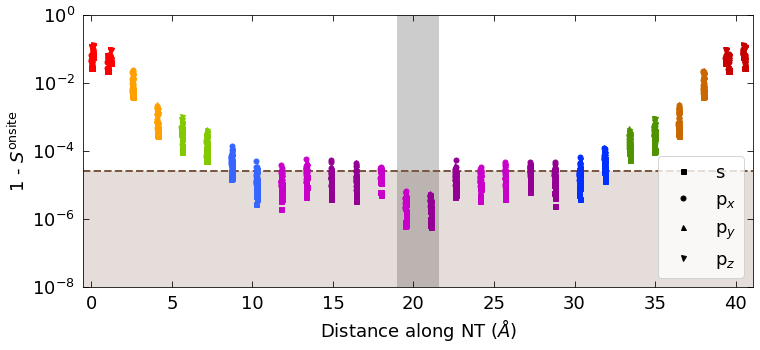

In [33]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,5))
ax = plt.axes()
ax.set_yscale('log', nonposy='clip')   

plt.axvspan(mind - buffer, maxd + buffer, color=colors[0], alpha=0.2, lw=0)
# plot also the maximum periodic OO to give a reference 'zero'
plt.axhline(max_oop, color=colors[2], lw=widths[1], ls='--')
plt.axhspan(min_oop, max_oop, color=colors[2], alpha=0.2, lw=0)
    
for i, ooi in enumerate(oo['s']):
    iat = oo['s'][i][0]  
    ifrag = oo['s'][i][1]
    [fn, ifr] = SiC.get_frag_colour(ifrag, max_write_units/2, max_write_units/2+1, tf, False)
            
    # extract the element to simplify the lines below
    oos = 1.0 - abs(oo['s'][i][2])
    oopx = 1.0 - abs(oo['px'][i][2])
    oopy = 1.0 - abs(oo['py'][i][2])
    oopz = 1.0 - abs(oo['pz'][i][2])
    
    plt.semilogy(curves[0]['distances'][iat-1], abs(oos), marker=markers[0], ms=sizes[2], color=colors[fn])
    plt.semilogy(curves[0]['distances'][iat-1], abs(oopx), marker=markers[1], ms=sizes[3], color=colors[fn])
    plt.semilogy(curves[0]['distances'][iat-1], abs(oopy), marker=markers[2], ms=sizes[4], color=colors[fn])
    plt.semilogy(curves[0]['distances'][iat-1], abs(oopz), marker=markers[3], ms=sizes[5], color=colors[fn])
    
#just for the sake of the key
plt.semilogy(dmax+1, 1, color=colors[0], ls='', marker=markers[0], ms=sizes[2], label='s')
plt.semilogy(dmax+1, 1, color=colors[0], ls='', marker=markers[1], ms=sizes[3], label='p$_x$')
plt.semilogy(dmax+1, 1, color=colors[0], ls='', marker=markers[2], ms=sizes[4], label='p$_y$')
plt.semilogy(dmax+1, 1, color=colors[0], ls='', marker=markers[3], ms=sizes[5], label='p$_z$')

set_plot_parameters(ax, dmin - buffer, dmax + buffer, oomin, oomax, dlabel, olabel, 'DEFAULT', 'DEFAULT',
                'DEFAULT', 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'lower right')

plt.show()

Plot also the correlation between average onsite overlap values and the errors in energy.

First change some of the parameters for plotting.

In [34]:
oomin = 1.0e-6
oomax = 2.0e-2

emin = 0.001
emax = 1.5
elabel = '$\Delta E$ (eV/atom)'

Fit the data and generate values for plotting.

In [35]:
oo_av_both = [oo_avp] + [oo_av[ifr] for ifr in range(1,max_write_units/2)] 
energies_both = [curvesp[2]['error_linear']] \
                + [curves[ifr+3]['error_linear'] for ifr in range(1,max_write_units/2)]
    
# take the average of the upper and lower error bars
errors_both = [0.5 * ((oo_avp - min_oop) + (max_oop - oo_avp))] \
                + [0.5 * ((oo_av[ifr] - oo_min[ifr]) + (oo_max[ifr] - oo_av[ifr]))
                  for ifr in range(1,max_write_units/2)]
std_both = [oo_stdp] + [oo_std[ifr] for ifr in range(1,max_write_units/2)]

full_oo = [1.e-8*o for o in range(0,10000001)]
mo, co = curve_fit(line, oo_av_both, energies_both, sigma=std_both)[0]
full_energies = [line(o, mo, co) for o in full_oo]

Plot the graph.

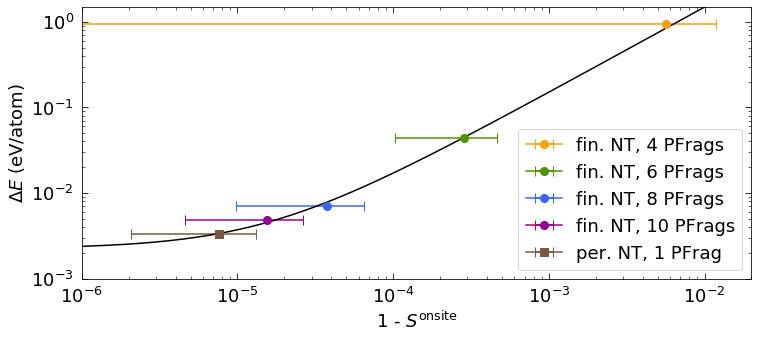

In [36]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,5))
ax = plt.axes()
ax.set_yscale('log', nonposy='clip')   
ax.set_xscale('log', nonposx='clip')   

plt.plot(full_oo, full_energies, ls='-', color=colors[0])

for ifr in range(1,max_write_units/2):        
    xerr = [[oo_av[ifr] - oo_min[ifr]], [oo_max[ifr] - oo_av[ifr]]]
    #print oo_av[ifr], oo_min[ifr], oo_max[ifr], oo_std[ifr]
    stderr = oo_std[ifr]
    plt.errorbar(oo_av[ifr], curves[ifr+3]['error_linear'], xerr=stderr, 
                 label='fin. NT, '+curves[ifr+3]['label'],
                 marker=markers[1], ms=sizes[0], color=colors[ifr+3], capsize=5)

xerr = [[oo_avp - min_oop], [max_oop - oo_avp]]

plt.errorbar(oo_avp, curvesp[2]['error_linear'], xerr=oo_stdp,
             label='per. NT, '+curvesp[2]['label'],
             marker=markers[0], ms=sizes[0], color=colors[2], capsize=5)

set_plot_parameters(ax, oomin, oomax, emin, emax, olabel, elabel, 'DEFAULT', 'DEFAULT',
                'DEFAULT', 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'lower right')

plt.show()

## Electronic Density

Read in information about the electronic densities.  These have been calculated separately using a Fortran program to calculate the difference between two cube files.  Note that there will be no files found for linear-linear or cubic-linear, these are not needed.

In [37]:
ref = 'density_'+str(full_units)+'_linear'
densities = [SiC.read_density('density_'+str(full_units)+'_'+calc_type+'_avg_z.dat',
            curves[0]['zmin']+curves[0]['zshift'])
            for i,calc_type in enumerate(calc_types)]
density_diffs = [SiC.read_density('density_'+str(full_units)+'_'+calc_type+'_'+ref+'_avg_z.dat',
            curves[0]['zmin']+curves[0]['zshift'])
            for i,calc_type in enumerate(calc_types)]

refp = 'densityp_'+str(full_units)+'_linear'
densitiesp = [SiC.read_density('densityp_'+str(full_units)+'_'+calc_type+'_avg_z.dat',
            curvesp[0]['zmin']+curvesp[0]['zshift'])
            for i,calc_type in enumerate(calc_typesp)]
density_diffsp = [SiC.read_density('densityp_'+str(full_units)+'_'+calc_type+'_'+refp+'_avg_z.dat',
            curvesp[0]['zmin']+curvesp[0]['zshift'])
            for i,calc_type in enumerate(calc_typesp)]

density_14_cubic_density_14_linear_avg_z.dat not found
density_14_linear_density_14_linear_avg_z.dat not found
densityp_14_cubic_densityp_14_linear_avg_z.dat not found
densityp_14_linear_densityp_14_linear_avg_z.dat not found


Set some parameters for the plot.

In [38]:
zbuf = 4 # buffer along the z axis for plotting
ylabel1 = 'Av. $|\\rho|$ ($\AA^{-3}$)'
ylabel2 = 'Av. $|\Delta \\rho|$ ($\AA^{-3}$)'
ymax1 = 0.11
ymin2 = 1.e-6
ymax2 = 2.e-2
dx = 10
dy1 = 0.05

Display the density and density differences along the z-axis for the periodic NT.

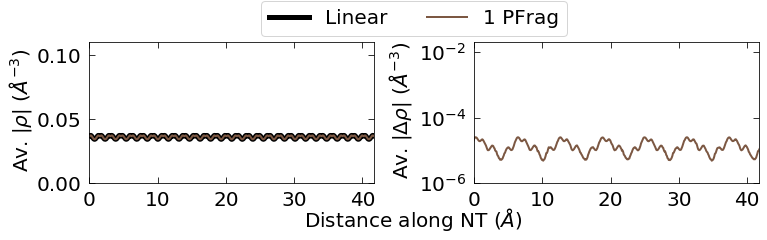

In [39]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 2, sharex='col', figsize=(12,2.7))
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.35)
fig.text(0.5, -0.1, dlabel, ha='center')
fig.text(0.03, 0.5, ylabel1, va='center', rotation='vertical')
fig.text(0.47, 0.5, ylabel2, va='center', rotation='vertical')

ls = []
data = densitiesp[2]
l = ax[0].plot(densitiesp[1]['z'], densitiesp[1]['rho'], marker="", 
        ls='-', lw=widths[0], label=curvesp[1]['label'], color=colors[0])
ls.append(l)       
l = ax[0].plot(data['z'], data['rho'], marker="", 
        ls='-', lw=widths[2], label=curvesp[2]['label'], color=colors[2])
ls.append(l)

set_plot_parameters(ax[0], dmin, dmaxp, 0, ymax1, 'NONE', 'NONE', 'DEFAULT', 'DEFAULT',
                dx, dy1, 'DEFAULT', 'DEFAULT', 1.0, 'NONE')
    
data = density_diffsp[2]
ddmax = 0.0
for d in density_diffsp[2]['rho']:
    ddmax = max(ddmax, d)
l = ax[1].semilogy(data['z'], data['rho_abs'], marker="", 
        ls='-', lw=widths[2], label=curvesp[2]['label'], color=colors[2])
    
set_plot_parameters(ax[1], dmin, dmaxp, ymin2, ymax2, 'NONE', 'NONE', 'DEFAULT', 'DEFAULT',
                dx, 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'NONE')

lss = ls[0] + ls[1]
for i in range(1,len(ls)-1):
    lss = lss + ls[i+1]    
labs = [l.get_label() for l in lss]
fig.legend(lss, labs, loc=[0.34,0.85], ncol=3)
plt.subplots_adjust(top=0.85)

plt.show()

Display the density and density differences along the z-axis for the different setups for the finite NT.

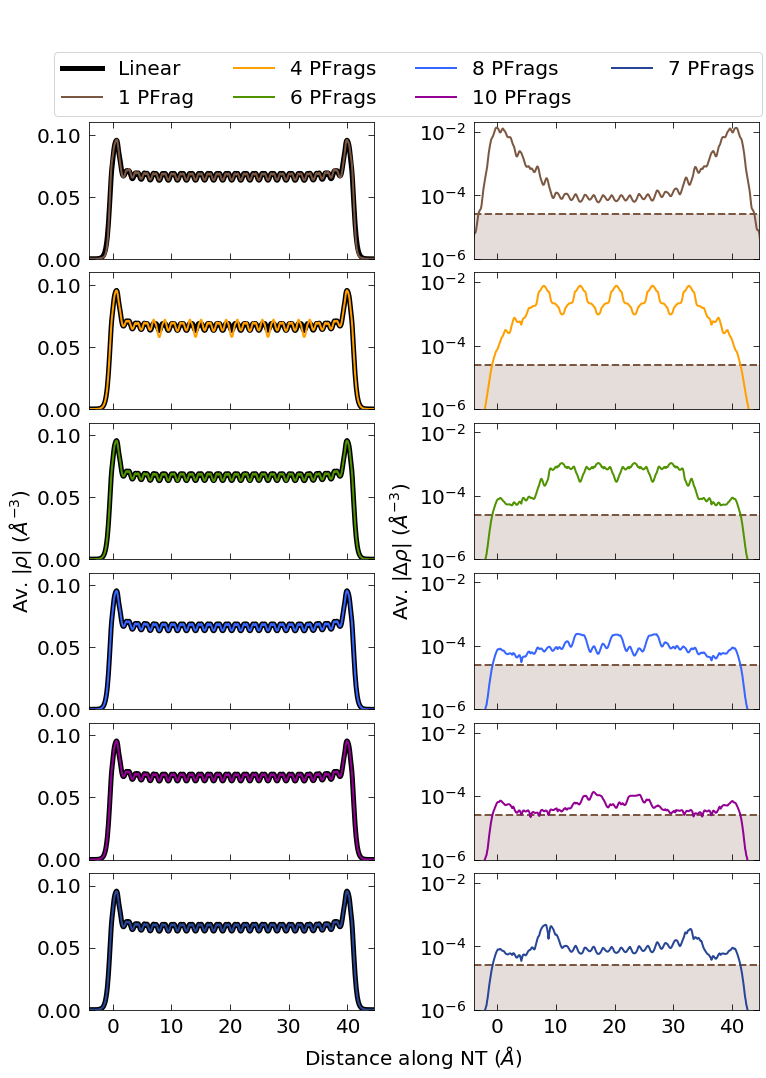

In [40]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(6, 2, sharex='col', figsize=(12,17))
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.35)
fig.text(0.5, 0.08, dlabel, ha='center')
fig.text(0.03, 0.5, ylabel1, va='center', rotation='vertical')
fig.text(0.47, 0.5, ylabel2, va='center', rotation='vertical')

ls = []
for i, (data, data_diff) in enumerate(zip(densities,density_diffs)):
    # skip linear as we're plotting that underneath anyway
    if i == 0 or i == 1 or i == 3:
        continue   
    if i <= 2:
        a = i - 2
    else:
        a = i - 3
    b = 0
    
    if a == 5:
        xtl = 'DEFAULT'
    else:
        xtl = 'NOLABEL'
    
    l = ax[a][b].plot(densities[1]['z'], densities[1]['rho'], marker="", 
            ls='-', lw=widths[0], label=curves[1]['label'], color=colors[0])
    if i == 2:  
        ls.append(l)  
    l = ax[a][b].plot(data['z'], data['rho'], marker="", 
             ls='-', lw=widths[i], label=curves[i]['label'], color=colors[i])
    ls.append(l)
    
    ax[a][b].set_xlim([dmin - zbuf, dmax + zbuf])
    ax[a][b].set_ylim([0.0, ymax1])
    ax[a][b].yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    
    set_plot_parameters(ax[a][b], dmin - zbuf, dmax + zbuf, 0, ymax1, 'NONE', 'NONE', xtl, 'DEFAULT',
                dx, dy1, 'DEFAULT', 'DEFAULT', 1.0, 'NONE')
    
    b = 1 
    ax[a][b].axhline(ddmax, color=colors[2], lw=widths[1], ls='--')
    ax[a][b].axhspan(ymin2, ddmax, color=colors[2], alpha=0.2, lw=0)
    
    l = ax[a][b].semilogy(data_diff['z'], data_diff['rho_abs'], marker="", 
            ls='-', lw=widths[i], label=curves[i]['label'], color=colors[i])
    
    set_plot_parameters(ax[a][b], dmin - zbuf, dmax + zbuf, ymin2, ymax2, 'NONE', 'NONE', xtl, 'DEFAULT',
                dx, 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'NONE')

lss = ls[0] + ls[1]
for i in range(1,len(ls)-1):
    lss = lss + ls[i+1]    
labs = [l.get_label() for l in lss]
fig.legend(lss, labs, loc=[0.07,0.892], ncol=4) 
plt.subplots_adjust(top=0.85)
    
plt.show()

## Size Scaling

In the following we increase the length of the NTs. From now on we use the linear scaling calculations as the reference values.

First set some general variables.

In [41]:
min_units = 10                 # the minimum number of units in the full system
max_units = 42                 # the maximum number of units in the full system
dunits = 4                     # the number of units to increase each time
nedge = 3                      # the number of rings to be included as a part of the termination at each edge

min_frag_units = 8             # the first template calculation type
max_frag_units = 10            # the last template calculation type
find = min_frag_units/2 + 2    # index for the above fragment calculation
findm = max_frag_units/2 + 3   # index for the mixed fragment calculation
find2 = find + 1               # index for 2nd fragment calculation

Create the input files for increasing length NTs.

In [42]:
# we just want total energies, so no need to diagonalize, also don't need onsite overlap
linear_dict['lin_general'].update({'output_mat': 0, 'calculate_onsite_overlap': False,
                                   'subspace_diag': False}) 
linear_dict['dft'].update({'output_denspot': 0}) 

read_dict['lin_general'].update({'subspace_diag': False}) 
read_dict['dft'].update({'output_denspot': 0}) 

for units in range(min_units,max_units+dunits,dunits): 
    # no need to redo the calculations from above
    if units == full_units:
        continue
    
    # make each of the read.yaml files for the given template setup
    rname = seed+"_"+str(units)
    rnat = units * nat_ring * 2
    rnum_frags = rnat / nat_frag
    pos_dict = {'posinp': rname}
    read_dict.update(pos_dict)

    # use the appropriate template fragments
    for w in range(min_frag_units, max_frag_units + 2, 2):
        # set the variables corresponding to the template calculation
        wname = seed+"_"+str(w)
        wnat = w * nat_ring * 2
        wnum_frags = wnat / nat_frag

        fdict1 = {'frag'+str(f)+'_fw'+str(w): [f] for f in range(1,w/2)} 
        fc=w/2
        fdict2 = {'frag'+str(fc)+'_fw'+str(w): [f for f in range(fc,rnum_frags-w/2+2,2)]}  
        fc=w/2+1
        fdict3 = {'frag'+str(fc)+'_fw'+str(w): [f for f in range(fc,rnum_frags-w/2+2,2)]}
        fdict4 = {'frag'+str(f)+'_fw'+str(w): [rnum_frags - wnum_frags + f] for f in range(w-w/2+2,w+1)}
        fdict4.update(fdict3)
        fdict4.update(fdict2)
        fdict4.update(fdict1)
        rfrag_dict = {'frag': fdict4}
        read_dict.update(rfrag_dict)
        rad_dict = {'radical': wname+'_fw'}
        read_dict.update(rad_dict)
        Y.dump(read_dict,rname+"_fr"+str(w)+".yaml")
    
        if w == min_frag_units + 2:
            continue
            
        # write also the mixed periodic/finite template read.yaml
        fdict1 = {'frag'+str(f)+'_fw'+str(w): [f] for f in range(1,w/2)} 
        fc=w/2
        fdict2 = {'frag_fw'+str(pw_units): [f for f in range(fc,rnum_frags-w/2+2)]}  
        fdict4 = {'frag'+str(f)+'_fw'+str(w): [rnum_frags - wnum_frags + f] for f in range(w-w/2+2,w+1)}
        fdict4.update(fdict2)
        fdict4.update(fdict1)
        rfrag_dict = {'frag': fdict4}
        read_dict.update(rfrag_dict)
        rad_dict = {'radical': wname+'_fw'}
        read_dict.update(rad_dict)
        Y.dump(read_dict,rname+"_fr"+str(w)+"m.yaml")

    # finally the linear .yaml file
    lname = seed+"_"+str(units)
    lnat = full_units * nat_ring * 2
    pos_dict = {'posinp': lname}
    rad_dict = {'radical': lname+'_linear'}
    linear_dict.update(pos_dict)
    linear_dict.update(rad_dict)
    Y.dump(linear_dict,lname+"_linear.yaml")

Extract the total energies from the different calculation setups.

In [43]:
inds = [1, find, find2, findm]

curves_size = [[SiC.get_data(seed, calc_types[ind], units, smear, labels[ind],
                        '0', get_dos=False, get_pos=False, get_error=False)
                        for units in range(min_units, max_units+dunits, dunits)] for ind in inds]

Define an expression for the energy of a NT containing a given number of units.

In [44]:
def energy(n, eb, et):
    return (n - nedge*2)*eb + 2*et

Determine the values of the bulk and edge energies by fitting to the energies calculated using the different methods.

In [45]:
units_size = [[curves_size[i][c]['atoms']/nat_frag for c in range(len(curves_size[i]))]
                      for i in range(len(inds))]
energies_size = [[curves_size[i][c]['energy']*curves_size[i][c]['atoms'] for c in range(len(curves_size[i]))]
                      for i in range(len(inds))]
popts = []
pcovs = []
for i in range(len(inds)):
    popt, pcov = curve_fit(energy, units_size[i], energies_size[i])
    popts.append(popt)
    pcovs.append(pcov)

min_unitsp = 8
max_unitsp = max_units + dunits
full_atoms = [units * nat_frag for units in range(min_unitsp,max_unitsp)]
full_fit_energies = [[energy(units, *popts[i])/(units * nat_frag) for units in range(min_unitsp,max_unitsp)]
                    for i in range(len(inds))]

Plot the calculated energies and the curves generated by fitting to the above model.  As with the 'noisy' calculations, we also use the correlation between the Wahba cost function and errors to apply a correction to the pseudo-fragment energies.

Set some parameters for the plot.

In [75]:
# set axes labels
label_atoms = 'Number of atoms'
label_wahba = '$J_{\mathrm{Av.}} (\AA^2)$'
label_e = '$E_{\mathrm{finite}} - E_{\mathrm{periodic}}$ (meV/atom)'
label_de = '$E_{\mathrm{finite}} - E_{\mathrm{finite}}^{\mathrm{linear}}$ (meV/atom)'

# set the values for the x and y ranges
da = 75
amin = curves_size[0][0]['atoms'] - da
amax = curves_size[0][-1]['atoms'] + da
de = 8
emin = 1000 * (curves_size[0][-1]['energy'] - curvesp[1]['energy']) - de
emax = 1000 * (curves_size[3][0]['energy'] - curvesp[2]['energy']) + de
demin = 0
demax = 8
jmin = 0
jmax = 0.0045

# set x and y tick intervals
da = 250
dj = 0.001
de = 20
dde = 2

Make some arrays for plotting - these are the ones which are independent of the PFrag setup so need only be done once.

In [76]:
atoms = [curves_size[0][i]['atoms'] for i in range(len(curves_size[0]))]
full_wahbas = [0.001*w for w in range(0,41)]
linear_energies = [1000 * (curves_size[0][i]['energy'] - curvesp[1]['energy'])
                   for i in range(len(curves_size[0]))]
full_linear_fit = [1000 * (fe - curvesp[1]['energy']) for fe in full_fit_energies[0]]

Plot the data.

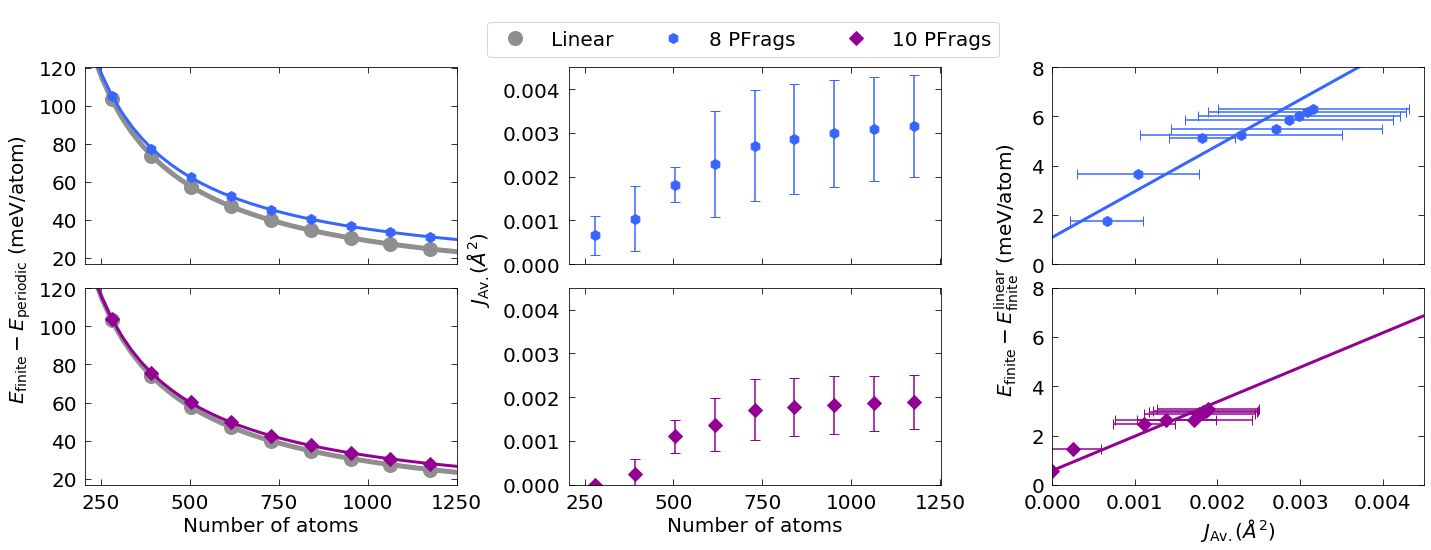

In [102]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(2, 3, sharex='col',figsize=(24,8))

fig.subplots_adjust(hspace=0.12)
fig.subplots_adjust(wspace=0.3)
fig.text(0.08, 0.5, label_e, va='center', rotation='vertical')
fig.text(0.345, 0.5, label_wahba, va='center', rotation='vertical')
fig.text(0.65, 0.5, label_de, va='center', rotation='vertical')

wfac = [0.2, 0.1, -0.5]
ls = []
for a in range(1,3):
    d = a - 1
    
    if d == 1:
        xtl = 'DEFAULT'
    else:
        xtl = 'NOLABEL'
    
    # make some arrays for plotting - these are the ones which are dependent on the PFrag setup
    wahbas = [curves_size[a][i]['wahba']['av'] for i in range(len(curves_size[0]))] 
    std = [curves_size[a][i]['wahba']['std'] for i in range(len(curves_size[0]))] 
    frag_energies = [1000 * (curves_size[a][i]['energy'] - curvesp[2]['energy'])
                     for i in range(len(curves_size[0]))]
    fit_energies = [1000 * (energy(atoms[i]/nat_frag, *popts[a])/atoms[i] - curvesp[2]['energy'])
                    for i in range(len(curves_size[0]))]
    full_frag_fit = [1000 * (fe - curvesp[2]['energy']) for fe in full_fit_energies[a]]
    fit_errors = [fit_energies[i] - linear_energies[i] for i in range(len(curves_size[0]))]
    errors = [frag_energies[i] - linear_energies[i] for i in range(len(curves_size[0]))]
    mf, cf = curve_fit(line, wahbas, errors, sigma=std)[0]
    full_est_errors = [line(wahba, mf, cf) for wahba in full_wahbas]
    full_noise_errors = [1000 * line(wahba, mn, cn) for wahba in full_wahbas]
    est_errors = [line(wahba, mf, cf) for wahba in wahbas]
    corr_errors = [error - est_errors[i] for i,error in enumerate(errors)]
    corr_frag_energies = [frag_energies[i] - est_errors[i] for i in range(len(curves_size[0]))]
    corr_frag_energies_to_fit = [(corr_frag_energies[i]/1000 + curvesp[2]['energy']) * atoms[i]
                                 for i in range(len(curves_size[0]))]
    poptc, pcovc = curve_fit(energy, units_size[a], corr_frag_energies_to_fit)
    full_corr_fit_energies = [energy(units, *poptc)/(units * nat_frag) for units in range(min_unitsp,max_unitsp)]
    full_corr_frag_fit = [1000 * (fe - curvesp[2]['energy']) for fe in full_corr_fit_energies]
    
    # plot energy 
    b = 0
    # first the linear values
    ax[d][b].plot(full_atoms, full_linear_fit, marker='', color=colors[inds[0]], ls='-', lw=lw[0])  
    for c in range(len(curves_size[0])):
        if c == 0 and a == 1:
            label = curves_size[0][0]['label']
        else:
            label = ''
        l = ax[d][b].plot(atoms[c], linear_energies[c], marker=markers[inds[0]], ms=ms[0],
                          color=colors[inds[0]], ls='', label=label)
        if c == 0 and a == 1:
            ls.append(l)
   
    # then the fragment values
    ax[d][b].plot(full_atoms, full_frag_fit, marker='', color=colors[inds[a]], ls='-', lw=lw[1], label=label)
    for c in range(len(curves_size[a])):
        if c == 0:
            label = curves_size[a][0]['label']
        else:
            label = ''
        l = ax[d][b].plot(atoms[c], frag_energies[c], marker=markers[inds[a]], ms=ms[1],
                          color=colors[inds[a]], ls='', label=label)
        if c == 0:
            ls.append(l)
    
    if d == 1:
        xlabel = label_atoms
    else:
        xlabel = 'NONE'
    set_plot_parameters(ax[d][b], amin, amax, emin, emax, xlabel, 'NONE', xtl, 'DEFAULT',
                        da, de, 'DEFAULT', 'DEFAULT', 1.0, 'NONE')
    
    # plot Wahba
    b = 1
    ax[d][b].errorbar(atoms, wahbas, marker=markers[inds[a]], ms=ms[1], color=colors[inds[a]],
                      ls='', yerr=[std, std], capsize=5)
    set_plot_parameters(ax[d][b], amin, amax, jmin, jmax, xlabel, 'NONE', xtl, 'DEFAULT',
                        da, dj, 'DEFAULT', 'DEFAULT', 1.0, 'NONE')
    
    # plot Wahba v error
    b = 2
    l = ax[d][b].errorbar(wahbas, errors, marker=markers[inds[a]], ms=ms[1], color=colors[inds[a]], 
                      ls='', xerr=[std, std], capsize=5)  
    l = ax[d][b].plot(full_wahbas, full_est_errors, marker='', ms=ms[1], color=colors[inds[a]],
                      ls='-', lw=lw[1])

    if d == 1:
        xlabel = label_wahba
    else:
        xlabel = 'NONE'
    set_plot_parameters(ax[d][b], jmin, jmax, demin, demax, xlabel, 'NONE', xtl, 'DEFAULT',
                        dj, dde, 'DEFAULT', 'DEFAULT', 1.0, 'NONE')
    
lss = ls[0] + ls[1]
for i in range(1,len(ls)-1):
    lss = lss + ls[i+1]    
labs = [l.get_label() for l in lss]
fig.legend(lss, labs, loc=[0.34,0.895], ncol=3)
 
plt.subplots_adjust(top=0.85)
plt.show()